<a href="https://colab.research.google.com/github/sewon3191/2021_cphys2/blob/main/final_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Image classification with CNN

- cnn을 이용하여 다음 이미지를 분류하여라.
- 인풋 데이터는 rgb 정보를 가지고 있다.
- 코드, 결과, 보고서를 함께 제출하여야 한다.
- 주의! 자신의 코드에 대한 설명과 결과에 대한 해석을 보고서로 함께 작성
- 보고서는 코드 아래에 마크다운을 이용해서 작성할 것

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
batch_size = 4 #batch 사이즈 설정

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False
)

classes = trainset.classes
classes

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

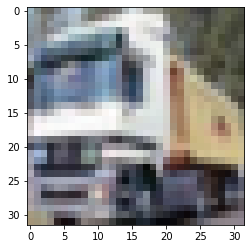

In [3]:
images=train_loader.dataset[1][0]
plt.imshow(images.permute(1, 2, 0))

In [4]:
images.size() # [3, 32, 32]: 3 -> RGB, 32x32 

torch.Size([3, 32, 32])

In [5]:
import torch.nn as nn 
class net(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3,padding=1) #레이어구성
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8 * 8* 8, 25)
        self.fc2 = nn.Linear(25, 15)
        self.fc3 = nn.Linear(15, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x) # ReLU로 미분 값이 0과 1만을 가지고 계속 작아지는 문제 수정
        x = nn.functional.max_pool2d(x, 2) #최댓값만 모으기
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)

        # fully connected
        x = nn.functional.relu(x)
        x = nn.functional.relu(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        return x

In [6]:
model = net()

# loss and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [7]:
model

net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=10, bias=True)
)

In [8]:
# training
def train(model, criterion, optimizer, data):
    model.train()
    for X,y in data:
        y_pred = model(X)
        loss = criterion(y_pred,y)
        
        optimizer.zero_grad() #미분값 초기화
        loss.backward() #역전파
        optimizer.step()

In [9]:
def evaluation(model, criterion, optimizer, data):
    model.eval() 
    test_loss = 0
    accuracy = 0
    size=0

    with torch.no_grad():
        for x, y in data:
            y_pred = model(x)
            test_loss = criterion(y_pred, y).item()
            prediction = y_pred.max(1)[1]
            size +=y.size(0)
            accuracy += (prediction == y).sum().item()
            accu_size = accuracy/size
    return test_loss, accu_size

In [10]:
nums_epoch = 30
for epoch in range(nums_epoch):
    train(model, criterion, optimizer, train_loader)
    
    if(epoch%3==0):
        E, accu = evaluation(model, criterion, optimizer, test_loader)
        print(epoch, "loss=", E, "accu=", accu)

0 loss= 1.0996075868606567 accu= 0.442
3 loss= 0.8209631443023682 accu= 0.5142
6 loss= 1.2869141101837158 accu= 0.5304
9 loss= 0.6318536996841431 accu= 0.561
12 loss= 0.6635444164276123 accu= 0.5788
15 loss= 0.9679754376411438 accu= 0.5777
18 loss= 0.7220430970191956 accu= 0.5828
21 loss= 0.8375237584114075 accu= 0.5736
24 loss= 0.781477689743042 accu= 0.5771
27 loss= 0.6763209104537964 accu= 0.5853


CNN 을 활용하여 이미지를 분류하는 프로그램을 작성하였다. 최족 정확도는 58퍼센트가 나왔다. 기존에 과제에서 사용하던 구조가 아닌 새로운 모델로 했어야 했다. 최초조건으로 주어진 양식에 맞춰서 시작하였으며 기본 프로그램 형태는 CNN 방식으로 하였고 epoch 사이즈는 30으로 하였다.